# Train with fastai
This Jupyter notebook uses [fastai](https://github.com/fastai/fastai), a Python library for deep learning, to train a convolutional neural network (CNN) on an image dataset. The notebook loads and preprocesses the image data, then uses a pretrained CNN architecture from the [timm](https://github.com/huggingface/pytorch-image-models) library to fine-tune the model on the dataset. Finally, the trained model is saved for future use.

<!--<badge>--><a href="https://colab.research.google.com/github/visual-layer/vl-datasets/blob/master/notebooks/train-fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

## Installation & Setting Up

Eventually we will run

`!pip install vl-datasets`

but for now

In [ ]:
!pip install fastai -Uqq
!pip install timm -Uqq
!git clone https://github.com/visual-layer/vl-datasets && cd vl-datasets && pip install -e .

## Define the preprocessing transforms
We define the preprocessing transforms for the dataset. We have two transforms: `train_transform` and `valid_transform`.

In [1]:
import torchvision.transforms as transforms

train_transform = transforms.Compose(
    [
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

valid_transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

## Download and load the food-101 Dataset

The easiest way to get the clean version of food-101 dataset is to use `vl_dataset` package.

In [2]:
from vl_datasets import CleanFood101

train_dataset = CleanFood101('./', split='train', exclude_csv='food_101_vl-datasets_analysis.csv', transform=train_transform)
valid_dataset = CleanFood101('./', split='test', exclude_csv='food_101_vl-datasets_analysis.csv', transform=valid_transform)

Excluded 407 from the train set
Excluded 91 from the test set


Upon completion, you'd have with a `food-101` folder in your local directory.

```
food-101/
├── images
│   ├── apple_pie
│   │   ├── 0001.jpg
│   │   └── 0002.jpg
│   ├── baby_back_ribs
│   ├── baklava
│   ├── ...
│   ├── ...
│   ├── ...
│   └── waffles
├── meta
|   ├── classes.txt
│   ├── labels.txt
│   ├── test.json
│   ├── test.txt
│   ├── train.json
│   └── train.txt
├── license_agreement.txt
└── README.txt
```


If you'd like to download the food-101 manually, you run the following codes to download and extract the folder into your local directory.

```shell
wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
tar -xf food-101.tar.gz
```

Next, load the directory into a `CleanFood101` class.

```python
train_dataset = CleanFood101('./', download=False, split='train', exclude_csv='food_101_vl-datasets_analysis.csv', transform=train_transform)
valid_dataset = CleanFood101('./', download=False, split='test', exclude_csv='food_101_vl-datasets_analysis.csv', transform=train_transform)
```

View the list of excluded files.

In [3]:
print(train_dataset.excluded_files[:5])

['churros/1440917.jpg', 'churros/1944265.jpg', 'churros/3867252.jpg', 'churros/644700.jpg', 'hot_and_sour_soup/1674538.jpg']


In [4]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=256, shuffle=True)

Convert PyTorch `Dataloader` to fastai `Dataloader` class.

In [5]:
from fastai.data.core import DataLoaders
dls = DataLoaders(train_loader, valid_loader)

## Import Libraries

The `fastai.vision.all` module contains all the classes and functions for computer vision tasks in the fastai library, while the timm library provides a collection of state-of-the-art CNN architectures for image classification.

In [6]:
from fastai.vision.all import *

## Define and Train the Model

The next step is to define and train the CNN model using the Fastai library. The following code defines a vision learner with the convnext_tiny_in22k architecture from the timm library and the accuracy metric.

The vision_learner function creates a CNN model with the specified architecture and data, and the metrics argument specifies the evaluation metric to use during training. In this case, the accuracy metric is used to measure the percentage of correctly classified images. The to_fp16 method is used to convert the model to half-precision floating-point format, which reduces memory usage and speeds up training.

You can optionally use model from `timm` in fastai. For example:

```python
import timm
model = timm.create_model("hf-hub:timm/eca_nfnet_l0", pretrained=True)
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropy(), metrics=accuracy, opt_func=ranger).to_fp16()
```

In [7]:
learn = Learner(dls, resnet18(), loss_func=LabelSmoothingCrossEntropy(), metrics=accuracy).to_fp16()

The next step is to find the optimal learning rate for training the model using the following code:

SuggestedLRs(valley=0.0010000000474974513)

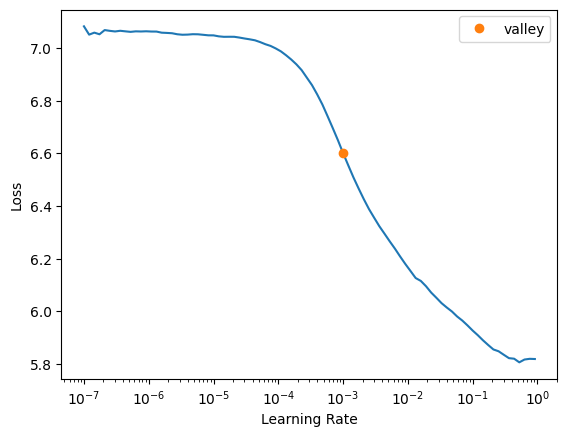

In [8]:
learn.lr_find()

This function finds the learning rate that results in the steepest decrease in the loss function during training, which is a good starting point for fine-tuning the model.

Finally, the following code is used to fine-tune the model on the dataset for 5 epochs with a learning rate of 1e-3 and a ShowGraphCallback to plot the training and validation loss over time:



epoch,train_loss,valid_loss,accuracy,time
0,4.689051,4.663916,0.088279,04:30


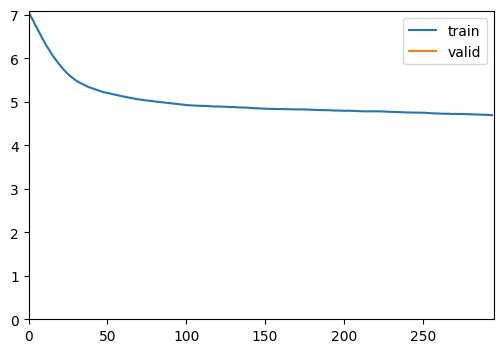

epoch,train_loss,valid_loss,accuracy,time
0,4.284242,4.141407,0.171628,04:31
1,4.016786,4.252418,0.178505,04:33
2,3.652960,3.523239,0.310903,04:33
3,3.338487,2.908187,0.465758,04:33
4,3.143864,2.743394,0.510434,04:32


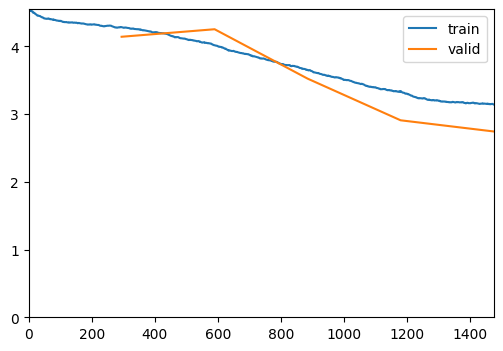

In [9]:
learn.fine_tune(5, base_lr=5e-3, cbs=[ShowGraphCallback()])

The fine_tune method is used to fine-tune the model on the dataset for the specified number of epochs, and the base_lr argument specifies the learning rate to use for the final layers of the model. The ShowGraphCallback is a custom callback that plots the training and validation loss over time.



## Evaluate Results
Once of the ways to learn about the performance of your model is to evaluate it on the validation set. For classification tasks it's easy to use confusion matrix to gauge the model performance.

In [15]:
# learn.get_preds(dls)

In [ ]:
# interp = ClassificationInterpretation.from_learner(learn)
# interp.plot_confusion_matrix(figsize=(5,5), dpi=60)

## Export the Trained Model

The export method is used to save the model to a file with the specified path and name. This trained model can be loaded later for inference or further fine-tuning.

In [ ]:
learn = learn.to_fp32()
learn.save('myModel', with_opt=False)

Path('models/myModel.pth')

That's it! This notebook shows how to train a CNN model using the Fastai library with a pretrained architecture from the timm library. By following the steps in this notebook, you can easily train your own CNN models on image datasets using fastai.



